In [40]:
%pip install z3-solver
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 7.7 MB/s  0:00:01 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.7 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [2]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
s = Solver()

In [33]:
# Constants
chip_size = (30, 30)
component_sizes =  [[4,5],
                    [4,6],
                    [5,20],
                    [6,9],
                    [6,10],
                    [6,11],
                    [7,8],
                    [7,12],
                    [10,10],
                    [10,20]]
power_component_size = (4,3)
min_distance_power_components = 16

In [4]:
# Init variables respresenting start x and y of the power components and their orientation
power0_x = Int("power0_x")
power0_y = Int("power0_y")
power0_is_vertical = Bool("power0_is_vertical")

power1_x = Int("power1_x")
power1_y = Int("power1_y")
power1_is_vertical = Bool("power1_is_vertical")

In [5]:
# Init variables for every other component
xyb = []
for idx, size in enumerate(component_sizes):
    comp_x = Int(f"comp{idx}_x")
    comp_y = Int(f"comp{idx}_y")
    comp_is_vertical = Bool(f"comp{idx}_is_vertical")
    xyb.append((comp_x, comp_y, comp_is_vertical))

In [6]:
# Add positivity constraints
s.add(power0_x >= 0, power0_y >= 0)
s.add(power1_x >= 0, power1_y >= 0)
for comp_x, comp_y, _ in xyb:
    s.add(comp_x >= 0, comp_y >= 0)

In [8]:
# Make sure components fit withing chip boundaries
s.add(If(power0_is_vertical, And(power0_x + power_component_size[0] < chip_size[0], power0_y + power_component_size[1] < chip_size[1]),
                             And(power0_x + power_component_size[1] < chip_size[0], power0_y + power_component_size[0] < chip_size[1])))

s.add(If(power1_is_vertical, And(power1_x + power_component_size[0] < chip_size[0], power1_y + power_component_size[1] < chip_size[1]),
                             And(power1_x + power_component_size[1] < chip_size[0], power1_y + power_component_size[0] < chip_size[1])))
for idx, packed_values in enumerate(xyb):
    comp_x, comp_y, comp_is_vertical = packed_values
    s.add(If(comp_is_vertical, And(comp_x + component_sizes[idx][0] < chip_size[0], comp_y + component_sizes[idx][1] < chip_size[1]),
                               And(comp_x + component_sizes[idx][1] < chip_size[0], comp_y + component_sizes[idx][0] < chip_size[1])))

In [9]:
# Adding constraints s.t. no component overlays another
# Non-overlap between the power components
s.add(Or(power1_x + If(power1_is_vertical, power_component_size[0], power_component_size[1]) <= power0_x,
         power0_x + If(power0_is_vertical, power_component_size[0], power_component_size[1]) <= power1_x,
         power1_y + If(power1_is_vertical, power_component_size[1], power_component_size[0]) <= power0_y,
         power0_y + If(power0_is_vertical, power_component_size[1], power_component_size[0]) <= power1_y))

for idx, (comp_x, comp_y, comp_is_vertical) in enumerate(xyb):
    # Non-overlap between power and regular components
    s.add(Or(comp_x + If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1]) <= power0_x,
             power0_x + If(power0_is_vertical, power_component_size[0], power_component_size[1]) <= comp_x,
             comp_y + If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0]) <= power0_y,
             power0_y + If(power0_is_vertical, power_component_size[1], power_component_size[0]) <= comp_y))
    s.add(Or(comp_x + If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1]) <= power1_x,
             power1_x + If(power1_is_vertical, power_component_size[0], power_component_size[1]) <= comp_x,
             comp_y + If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0]) <= power1_y,
             power1_y + If(power1_is_vertical, power_component_size[1], power_component_size[0]) <= comp_y))
    
    # Non-overlap inbetween regular components
    for idx2, (comp2_x, comp2_y, comp2_is_vertical) in enumerate(xyb[idx+1:]):
        s.add(Or(comp_x + If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1]) <= comp2_x,
                 comp2_x + If(comp2_is_vertical, component_sizes[idx2][0], component_sizes[idx2][1]) <= comp_x,
                 comp_y + If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0]) <= comp2_y,
                 comp2_y + If(comp2_is_vertical, component_sizes[idx2][1], component_sizes[idx2][0]) <= comp_y))


In [10]:
s.check()
s.model()


[comp4_y = 6,
 comp3_is_vertical = False,
 comp8_y = 19,
 comp5_y = 11,
 comp8_x = 2,
 power0_is_vertical = False,
 comp0_is_vertical = False,
 comp6_y = 7,
 comp0_x = 23,
 comp8_is_vertical = False,
 comp6_is_vertical = False,
 comp2_y = 2,
 comp6_x = 20,
 power0_x = 0,
 comp1_is_vertical = True,
 power1_y = 18,
 comp0_y = 14,
 comp1_x = 20,
 power0_y = 0,
 comp2_is_vertical = False,
 comp9_is_vertical = False,
 comp4_x = 0,
 power1_x = 24,
 comp4_is_vertical = False,
 comp9_y = 13,
 comp7_is_vertical = False,
 power1_is_vertical = True,
 comp5_x = 13,
 comp2_x = 9,
 comp9_x = 0,
 comp3_y = 0,
 comp5_is_vertical = False,
 comp3_x = 4,
 comp1_y = 19,
 comp7_x = 6,
 comp7_y = 12]

In [11]:
model = s.model()

In [12]:
model[power1_y]

18

# Visualizing the result

In [87]:
cmap = plt.get_cmap("Set3", 12)

labels = {
    0: "Unassigned",
    1: "Component 1",
    2: "Component 2",
    3: "Component 3",
    4: "Component 4",
    5: "Component 5",
    6: "Component 6",
    7: "Component 7",
    8: "Component 8",
    9: "Component 9",
    10: "Component 10",
    11: "Power Component"
}

def map_key2scale(key):
    return (key+0.5) * 11/12


In [ ]:
def translate_model_to_image(model):
    image_grid = np.zeros(chip_size)
    # color in the power components
    x = model[power0_x].as_long()
    y = model[power0_y].as_long()
    print(x, x+power_component_size[0])
    if model[power0_is_vertical]:
        image_grid[x : x + power_component_size[0], y : y + power_component_size[1]] = 11
    else:
        image_grid[x : x + power_component_size[1], y : y + power_component_size[0]] = 11
    x = model[power1_x].as_long()
    y = model[power1_y].as_long()
    if model[power1_is_vertical]:
        image_grid[x : x + power_component_size[0], y : y + power_component_size[1]] = 11
    else:
        image_grid[x : x + power_component_size[1], y : y + power_component_size[0]] = 11
    # color in the rest of the components
    for idx, (comp_x, comp_y, comp_is_vertical) in enumerate(xyb):
        x = model[comp_x].as_long()
        y = model[comp_y].as_long()
        print(idx + 1)
        if model[comp_is_vertical]:
            image_grid[x : x + component_sizes[idx][0], y : y + component_sizes[idx][1]] = idx + 1
        else:
            image_grid[x : x + component_sizes[idx][1], y : y + component_sizes[idx][0]] = idx + 1
    return image_grid

In [57]:
translate_model_to_image(model)

0 4
1
2
3
4
5
6
7
8
9
10


array([[11., 11., 11., 11.,  0.,  0.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [11., 11., 11., 11.,  0.,  0.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [11., 11., 11., 11.,  0.,  0.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
         9.,  9.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
         9.,  9.,  9.,  0.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
         9.,  9.,  9.,  0.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10.,

In [88]:
def visualize_result(model):
    image_grid = translate_model_to_image(model)
    #np.array([
        #[int(model[element].as_long()) for element in row]
        #for row in x
    #])
    #image_grid = np.random.randint(0,11,[30,30])
    #print(image_grid[0])
    fig, ax = plt.subplots()
    im = ax.imshow(image_grid, cmap="Paired", interpolation="nearest", origin="upper", aspect="equal")
    ax.set_xticks(np.arange(-0.5, 30, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 30, 1), minor=True)
    ax.grid(which="minor", color="black", linewidth=1)

    cbar = fig.colorbar(im, ax=ax, ticks=[map_key2scale(key) for key in labels.keys()])
    cbar.ax.set_yticklabels(list(labels.values()))
    plt.show() 

0 4
1
2
3
4
5
6
7
8
9
10


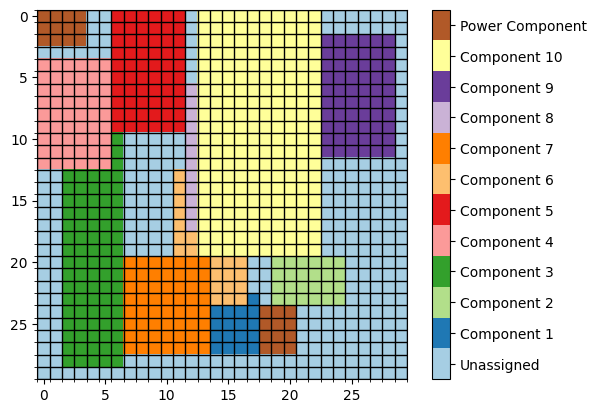

In [89]:
visualize_result(model)